# 3. Regression

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

## Regression intro

- What is regression
- Supervised learning

### Linear regression

- Linear model
- Common approaches
  - Least squares
  - Bayesian linear regression

### California housing dataset

The California housing dataset includes

In [2]:
housing_data = fetch_california_housing(as_frame=True)

df = housing_data['frame']
print(df.columns)

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedHouseVal'],
      dtype='object')


The housing data comprises of 8 features:

- `MedInc`: Median income of the population in the block.
- `HouseAge`: Average age of houses in the block.
- `AveRooms`: Average number of rooms in a house in the block.
- `AveBedrms`: Average number of bedrooms in a house in the block.
- `Population`: Population of the block.
- `AveOccup`: The average number of people living in a house.
- `Latitude`: Latitudinal position.
- `Logitude`: Longitudinal position.
- `MedHouseVal`: The median value of houses in the block.
 
The target feature is `MedHouseVal`.

We shall now look at the datatypes for each feature.

In [3]:
print(df.dtypes)

MedInc         float64
HouseAge       float64
AveRooms       float64
AveBedrms      float64
Population     float64
AveOccup       float64
Latitude       float64
Longitude      float64
MedHouseVal    float64
dtype: object


Each of the features are numerical, as is the target feature which makes regression easier.

### Geographical data

As the data is geographical it is a good idea to visualise it as such.

Using the `Latitude` and `Longitude` features we can plot the data as a scatter plot. Using the `alpha` parameter we can get an idea of population density across California.

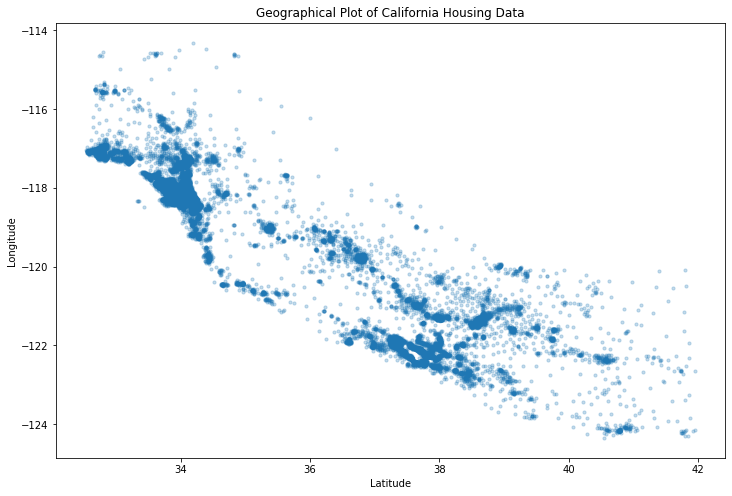

In [4]:
latitude = df['Latitude']
longitude = df['Longitude']

fig, ax = plt.subplots(figsize=(12, 8))
plt.title("Geographical Plot of California Housing Data")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.scatter(latitude, longitude, s=10, alpha=0.25)
plt.show()

We can assume the whitespace in the lower left corner is due to no houses being located in the ocean. This means the high density points are along the coast, which may have a high correlation with house price.

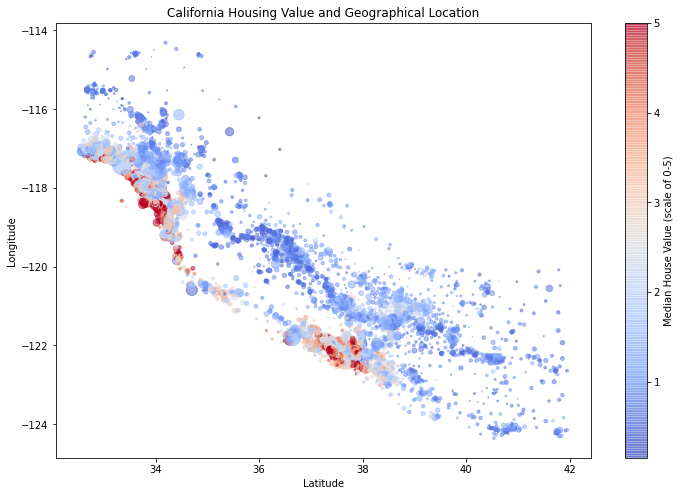

In [5]:
house_val = df['MedHouseVal']
population = df['Population']

fig, ax = plt.subplots(figsize=(12, 8))
plt.title("California Housing Value and Geographical Location")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.scatter(latitude, longitude, s=population/100, alpha=0.5, c=house_val, cmap='coolwarm')
plt.colorbar().set_label("Median House Value (scale of 0-5)")
plt.show()

From the scatter plot above we can see the more expensive (red) areas are closely packed, with the cheaper (blue) areas being far more scattered, as well as (generally) being further away from the coast. We can assume the more expensive areas relate to Los Angeles (north) and San Fransisco (south). We will need to ensure geographical data is encoded into the model as location evidetely has an impact on house price.

### Correlation and distribution

To get a quick look at the characteristics of the dataset we can use the `describe()` function.

In [6]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


From this we can see that some of the features have some large outlying values such as `AveRooms` and `AveOccup`, due to the max value being so much higher than the 75th percentile. We will have to handle this if we want to look at the histogram of the data as it may skew the results and not let us see the real distribution.

As we have already seen geographical data has a large impact on house value we will not explore its correlation with the other features any further. We will find the correlation between each of the remaining features.

In [7]:
non_geo = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms',
           'Population', 'AveOccup', 'MedHouseVal']

corr = df[non_geo].corr()
print(corr)

               MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
MedInc       1.000000 -0.119034  0.326895  -0.062040    0.004834  0.018766   
HouseAge    -0.119034  1.000000 -0.153277  -0.077747   -0.296244  0.013191   
AveRooms     0.326895 -0.153277  1.000000   0.847621   -0.072213 -0.004852   
AveBedrms   -0.062040 -0.077747  0.847621   1.000000   -0.066197 -0.006181   
Population   0.004834 -0.296244 -0.072213  -0.066197    1.000000  0.069863   
AveOccup     0.018766  0.013191 -0.004852  -0.006181    0.069863  1.000000   
MedHouseVal  0.688075  0.105623  0.151948  -0.046701   -0.024650 -0.023737   

             MedHouseVal  
MedInc          0.688075  
HouseAge        0.105623  
AveRooms        0.151948  
AveBedrms      -0.046701  
Population     -0.024650  
AveOccup       -0.023737  
MedHouseVal     1.000000  


We can see some inital results, such as income being highly correlated with house value but it will be easier to visualise as a correlation matrix.

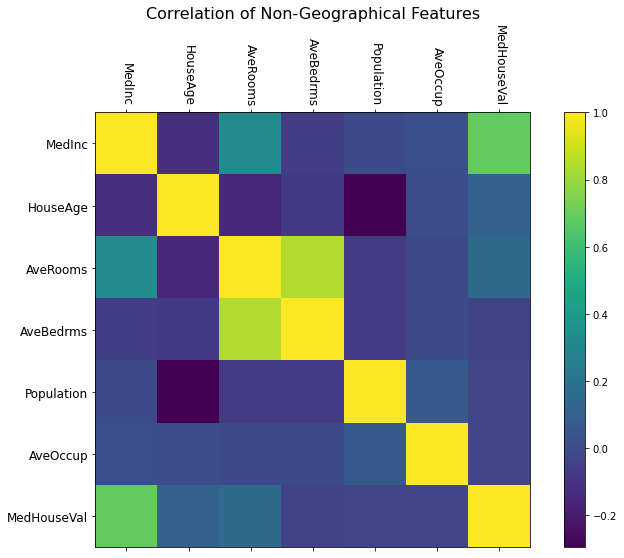

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Correlation of Non-Geographical Features", fontsize=16)
mat = ax.matshow(corr)
ax.set_xticks(range(len(non_geo)))
ax.set_yticks(range(len(non_geo)))
ax.set_xticklabels(non_geo, rotation=-90, fontsize=12)
ax.set_yticklabels(non_geo, fontsize=12)
plt.colorbar(mat, ax=ax)
plt.show()

We shall remove the highest values from some of the features with a long tail so we can get a better look at the disribution.

There are also some anomalies with the median house value and house age features. It seems that they have cut-offs of 5 and 50 repsectively and so there are a high number of them in the final bin on the histogram. This will have to be dealt with as to not skew the model.

In [10]:
df_nohigh = df[non_geo].astype(float)
df_nohigh = df_nohigh.drop(df_nohigh[(df_nohigh['MedInc'] > 10) |
                                     (df_nohigh['HouseAge'] > 50) |
                                     (df_nohigh['AveRooms'] > 10) |
                                     (df_nohigh['AveBedrms'] > 2) |
                                     (df_nohigh['Population'] > 6000) |
                                     (df_nohigh['AveOccup'] > 8) |
                                     (df_nohigh['MedHouseVal'] > 4.7)].index)

array([[<AxesSubplot:title={'center':'MedInc'}>,
        <AxesSubplot:title={'center':'HouseAge'}>,
        <AxesSubplot:title={'center':'AveRooms'}>],
       [<AxesSubplot:title={'center':'AveBedrms'}>,
        <AxesSubplot:title={'center':'Population'}>,
        <AxesSubplot:title={'center':'AveOccup'}>],
       [<AxesSubplot:title={'center':'MedHouseVal'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

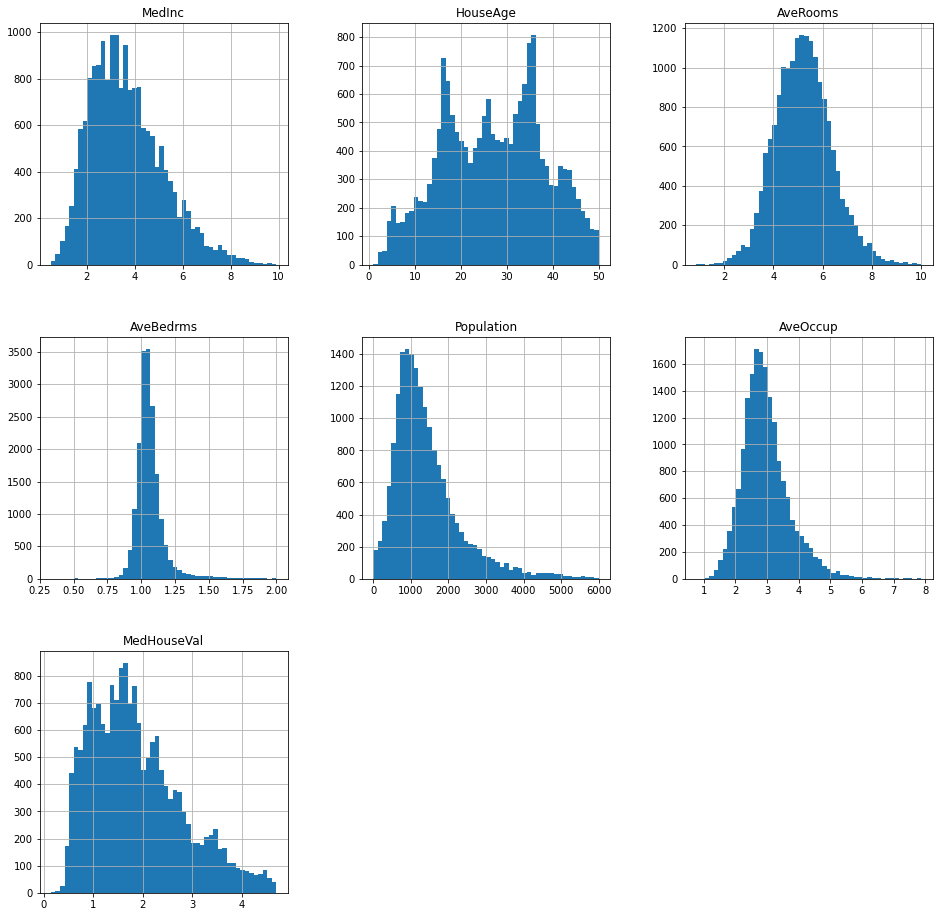

In [8]:
df_nohigh.hist(bins=50, figsize=(16, 16))

It appears most features have a gamma distribution - that is they generally follow a normal distribution with a long right-hand tail. This is due to a a small number of blocks having abnormally large, high value homes.

### Missing data

Missing data will cause issues when it comes to training a model, so we will need to check for and deal with any missing data points.

In [12]:
df.isnull().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

This seems to be a very clean dataset and does not have any missing values.

### Outliers

As with missing values, any outliers in the data could also cause our model to underperform.

Noted earlier there does seem to be outliers in the dataset.

In [ ]:
# handle outliers

There are also some issues with `MedHouseVal` and `HouseAge` being capped.

In [ ]:
# handle capped features

### Feature engineering and selection

It can be benificial to create additional features.

In [14]:
print(df.columns)

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedHouseVal', 'AveBedrmsPerRoom',
       'AveBedrmsPerOccup', 'AveAddRooms', 'EstHouses'],
      dtype='object')


In [15]:
df['AveBedrmsPerRoom'] = df['AveBedrms'] / df['AveRooms']
df['AveBedrmsPerOccup'] = df['AveBedrms'] / df['AveOccup']
df['AveAddRooms'] = df['AveRooms'] - df['AveBedrms']
df['EstHouses'] = df['Population'] / df['AveOccup']

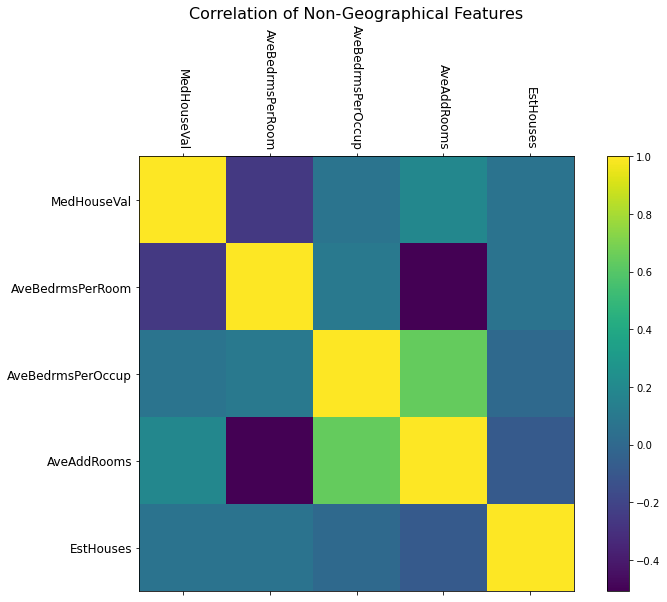

In [16]:
new_features = ['MedHouseVal', 'AveBedrmsPerRoom', 'AveBedrmsPerOccup', 
                'AveAddRooms', 'EstHouses']

new_features_corr = df[new_features].corr()

fig, ax = plt.subplots(figsize=(12,8))
ax.set_title("Correlation of Non-Geographical Features", fontsize=16)
mat = ax.matshow(new_features_corr)
ax.set_xticks(range(len(new_features)))
ax.set_yticks(range(len(new_features)))
ax.set_xticklabels(new_features, rotation=-90, fontsize=12)
ax.set_yticklabels(new_features, fontsize=12)
plt.colorbar(mat, ax=ax)
plt.show()

As discussed in part one reducing the number of dimensions can also be benificial for both the training time and generalisation of the model. This can be done by removing unnescessary features, but also by combining similar features.

In [17]:
corr = df.corr()
print(corr["MedHouseVal"].abs().sort_values(ascending=False))

MedHouseVal          1.000000
MedInc               0.688075
AveBedrmsPerRoom     0.255624
AveAddRooms          0.190680
AveRooms             0.151948
Latitude             0.144160
HouseAge             0.105623
AveBedrmsPerOccup    0.070602
EstHouses            0.065843
AveBedrms            0.046701
Longitude            0.045967
Population           0.024650
AveOccup             0.023737
Name: MedHouseVal, dtype: float64


### Categorical features

Categorical features in the data usually need to be encoded into numerical features for a machine learning algorithm to learn from them, especially with a regression model.

With this dataset there are only numerical features and all are of float type, so we can leave them as they are.

### Notes on sampling

- In group bias
- Ground truth
- Prior belief
- Sampling bias
- Selection bias
- Bias variance trade-off

## Bayesian Linear Regression

#### Bayes Theorem

- Bayes theorem
- Bayes rule
- Bayesian statistics

#### MCMC

- Markov chain
- Markov property
- MCMC
- Metropolis Hastings

#### Bayesian linear regression

- What is bayesian linear regression

#### Prior beliefs

- Prior for Bayesian
- Log-normal distribution

#### Prepare data for model

- Test train val split
- Scaling

In [18]:
print(df.columns)

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedHouseVal', 'AveBedrmsPerRoom',
       'AveBedrmsPerOccup', 'AveAddRooms', 'EstHouses'],
      dtype='object')


#### Spilt features and labels

Seperate features and labels and create new dataframes.

In [19]:
X_features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms',
              'Population', 'AveOccup', 'Latitude', 'Longitude',
              'AveBedrmsPerRoom', 'AveBedrmsPerOccup',
              'AveAddRooms', 'EstHouses']
y_features = ['MedHouseVal']

data = df
X = df[X_features]
y = df[y_features]

#### Get test and train sets

Create testing and training sets. Combine features and labels into train and test data frames.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [40]:
data_train = pd.concat((y_train, X_train), axis=1)
data_test = pd.concat((y_test, X_test), axis=1)

#### Create the model

Create initial Bayesian linear regression model with guassian priors.

In [18]:
def bayesian_linreg(data, formula):
    with pm.Model() as model:
        # Normal prior
        family = pm.glm.families.Normal()
        # Create model from formula
        pm.GLM.from_formula(formula, data=data_train, family=family)
        return model

#### Model sampler

Method to sample model and return trace.

In [20]:
def sample_model(n_samples=1000, n_tune=500, n_cores=2):
    trace = pm.sample(draws=n_samples, tune=n_tune,
                      progressbar=True, cores=n_cores)
    return trace

In [24]:
samples = 3000
tune = 500
cores = 16

formula = "MedHouseVal ~ MedInc + HouseAge + AveRooms + Latitude + Longitude\
           + AveBedrmsPerRoom + AveAddRooms + AveBedrmsPerOccup + EstHouses\
           + AveBedrms + Population + AveOccup"

with bayesian_linreg(data_train, formula):
    bayesian_linreg_trace = sample_model(samples, tune, cores)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [sd, AveOccup, Population, AveBedrms, EstHouses, AveBedrmsPerOccup, AveAddRooms, AveBedrmsPerRoom, Longitude, Latitude, AveRooms, HouseAge, MedInc, Intercept]


Sampling 16 chains for 500 tune and 3_000 draw iterations (8_000 + 48_000 draws total) took 77 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tr

In [ ]:
pm.traceplot(bayesian_linreg_trace)

In [ ]:
pm.plot_posterior(bayesian_linreg_trace)

#### Reducing complexity

Some features may not be adding valuable information to the model. They may just add complexity without improving model performance.

Let's look at the correlation of features to the target feature and see if any have particularly low correlation.

In [25]:
print(corr["MedHouseVal"].abs().sort_values(ascending=False))

MedHouseVal          1.000000
MedInc               0.688075
AveBedrmsPerRoom     0.255624
AveAddRooms          0.190680
AveRooms             0.151948
Latitude             0.144160
HouseAge             0.105623
AveBedrmsPerOccup    0.070602
EstHouses            0.065843
AveBedrms            0.046701
Longitude            0.045967
Population           0.024650
AveOccup             0.023737
Name: MedHouseVal, dtype: float64


We shall try dropping all non-geographical features with a correlation with `MedHouseVal` less than 0.1 as they may cause the model to overfit.

In [41]:
drop_features = ['AveBedrmsPerOccup', 'EstHouses', 'AveBedrms',
                 'Population', 'AveOccup']
X_train_less = X_train.drop(drop_features, axis=1, inplace=False)
data_train_less = data_train.drop(drop_features, axis=1, inplace=False)

We shall train the same model with the reduced feature set.

In [43]:
print(data_train_less.columns)

Index(['MedHouseVal', 'MedInc', 'HouseAge', 'AveRooms', 'Latitude',
       'Longitude', 'AveBedrmsPerRoom', 'AveAddRooms'],
      dtype='object')


In [29]:
formula = "MedHouseVal ~ MedInc + HouseAge + AveRooms + Latitude\
           + Longitude + AveBedrmsPerRoom + AveAddRooms"

with bayesian_linreg(data_train_less, formula):
    bayesian_linreg_trace = sample_model(3000, n_tune=5000, n_cores=16)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [sd, AveAddRooms, AveBedrmsPerRoom, Longitude, Latitude, AveRooms, HouseAge, MedInc, Intercept]


RuntimeError: Chain 3 failed.

## Optimisation

In [44]:
data_train_less.columns

Index(['MedHouseVal', 'MedInc', 'HouseAge', 'AveRooms', 'Latitude',
       'Longitude', 'AveBedrmsPerRoom', 'AveAddRooms'],
      dtype='object')

array([[<AxesSubplot:title={'center':'MedHouseVal'}>,
        <AxesSubplot:title={'center':'MedInc'}>,
        <AxesSubplot:title={'center':'HouseAge'}>],
       [<AxesSubplot:title={'center':'AveRooms'}>,
        <AxesSubplot:title={'center':'Latitude'}>,
        <AxesSubplot:title={'center':'Longitude'}>],
       [<AxesSubplot:title={'center':'AveBedrmsPerRoom'}>,
        <AxesSubplot:title={'center':'AveAddRooms'}>, <AxesSubplot:>]],
      dtype=object)

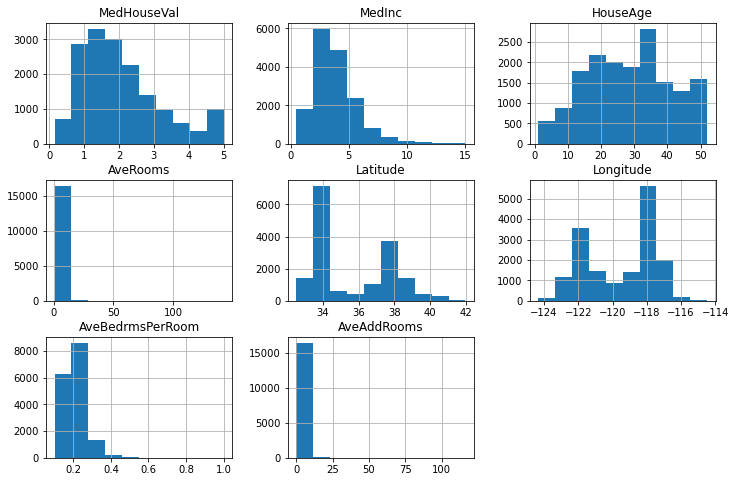

In [46]:
data_train_less.hist(figsize=(12, 8))

array([[<AxesSubplot:title={'center':'MedHouseVal'}>,
        <AxesSubplot:title={'center':'MedInc'}>,
        <AxesSubplot:title={'center':'HouseAge'}>],
       [<AxesSubplot:title={'center':'AveRooms'}>,
        <AxesSubplot:title={'center':'Latitude'}>,
        <AxesSubplot:title={'center':'Longitude'}>],
       [<AxesSubplot:title={'center':'AveBedrmsPerRoom'}>,
        <AxesSubplot:title={'center':'AveAddRooms'}>, <AxesSubplot:>]],
      dtype=object)

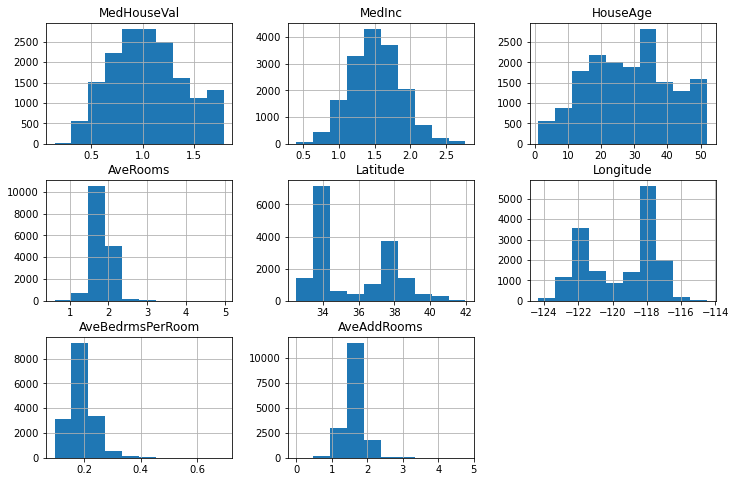

In [47]:
new_data = data_train_less

new_data["MedHouseVal"] = np.log1p(new_data['MedHouseVal'])
new_data["MedInc"] = np.log1p(new_data['MedInc'])
new_data["AveRooms"] = np.log1p(new_data['AveRooms'])
new_data["AveBedrmsPerRoom"] = np.log1p(new_data['AveBedrmsPerRoom'])
new_data["AveAddRooms"] = np.log1p(new_data['AveAddRooms'])

new_data.hist(figsize=(12, 8))

In [49]:
# LA location as north-westerly peak
la_lat, la_lon = 33, -117
# SF location as south-easterly peak
sf_lat, sf_lon = 37, -121

new_data['DistToLA'] = np.sqrt((new_data['Latitude'] - la_lat)**2 +
                               (new_data['Longitude'] - la_lon)**2)
new_data['DistToSF'] = np.sqrt((new_data['Latitude'] - sf_lat)**2 +
                               (new_data['Longitude'] - sf_lon)**2)

new_data['DistToCity'] = new_data[['DistToLA', 'DistToSF']].min(axis=1)

array([[<AxesSubplot:title={'center':'MedHouseVal'}>,
        <AxesSubplot:title={'center':'MedInc'}>],
       [<AxesSubplot:title={'center':'HouseAge'}>,
        <AxesSubplot:title={'center':'AveBedrmsPerRoom'}>],
       [<AxesSubplot:title={'center':'AveAddRooms'}>,
        <AxesSubplot:title={'center':'DistToCity'}>]], dtype=object)

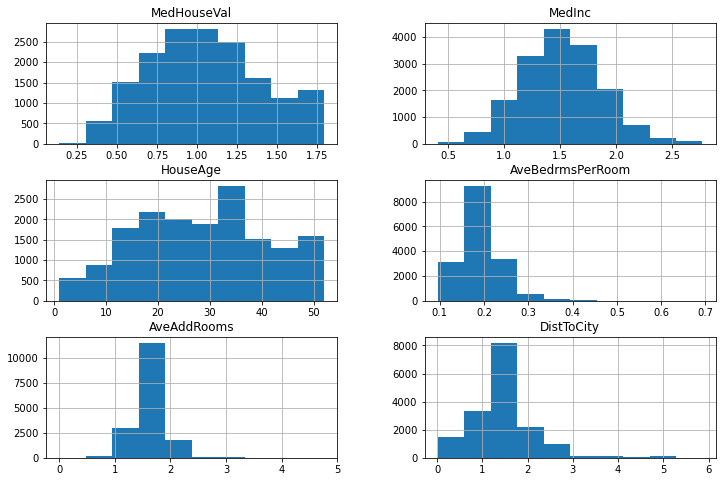

In [50]:
features = ['MedHouseVal', 'MedInc', 'HouseAge', 'AveBedrmsPerRoom',
            'AveAddRooms', 'DistToCity']

new_data = new_data[features]

new_data.hist(figsize=(12,8))

In [51]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(new_data)

print(scaled_data)

[[ 1.48848867  1.15157738  0.82252054 -0.97134666  0.78973893  0.15761205]
 [ 0.86493439  0.67310559 -0.84672507 -0.78832871  1.09212635  1.29965656]
 [-0.87907924  0.01036014 -0.0518462  -0.42980023  0.23392693 -1.70911827]
 ...
 [-0.13302479 -1.18280023  1.61739941  1.04326522 -1.08661942  0.08749433]
 [-1.7176986  -1.263279   -0.0518462   0.11696197 -0.29399975  0.31011181]
 [-0.20467133 -0.93609161 -0.36979775  0.88355491 -1.08818885 -0.02171399]]


array([[<AxesSubplot:title={'center':'MedHouseVal'}>,
        <AxesSubplot:title={'center':'MedInc'}>],
       [<AxesSubplot:title={'center':'HouseAge'}>,
        <AxesSubplot:title={'center':'AveBedrmsPerRoom'}>],
       [<AxesSubplot:title={'center':'AveAddRooms'}>,
        <AxesSubplot:title={'center':'DistToCity'}>]], dtype=object)

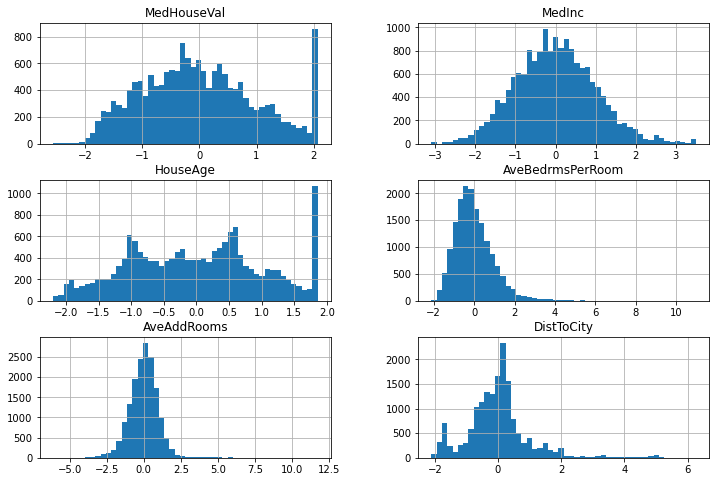

In [56]:
scaled_df = pd.DataFrame(scaled_data, columns=features)

scaled_df.hist(figsize=(12, 8), bins=50)

In [53]:
scaled_df.isnull().sum()

MedHouseVal         0
MedInc              0
HouseAge            0
AveBedrmsPerRoom    0
AveAddRooms         0
DistToCity          0
dtype: int64

---

## New model

In [85]:
print(features)

['MedHouseVal', 'MedInc', 'HouseAge', 'AveBedrmsPerRoom', 'AveAddRooms', 'DistToCity']


In [ ]:
formula = "MedHouseVal ~ MedInc + HouseAge +\
           AveBedrmsPerRoom + AveAddRooms + DistToCity"

with pm.Model() as model:
    # Normal prior
    family = pm.glm.families.Normal()
    # Create model from formula
    pm.GLM.from_formula(formula, data=scaled_df, family=family)
    trace = pm.sample(draws=8000, tune=2000,
                      progressbar=True, cores=16)

#### Pipeline

- Create pipeline

#### Performance measure

- Define the performance measure of the model.
- MSE / RMSE

#### Training the model

- Fit linear regressor

#### Evaluation of model

- Evaluate model performance on val / test set

#### Bayesian linear regression optimisation

- Hyper parameter tuning
- Feature engineering
- Feature selection
- Normalisation
- Distance to LA / SF
- Log of dataset
- Handle cut-offs
- Ridge / lasso regression

### Regression conclusion

- Concluding points on things learnt from dataset.
- Concluding points of Bayesian regression performance.